# Abalone Rings Regression Leveraging the Distribution of Rings

In [90]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [91]:
torch.manual_seed(42)
np.random.seed(42)

In [92]:
data = pd.read_csv('data/abalone.csv')

The distribution of the "Rings" is Gaussian-like.

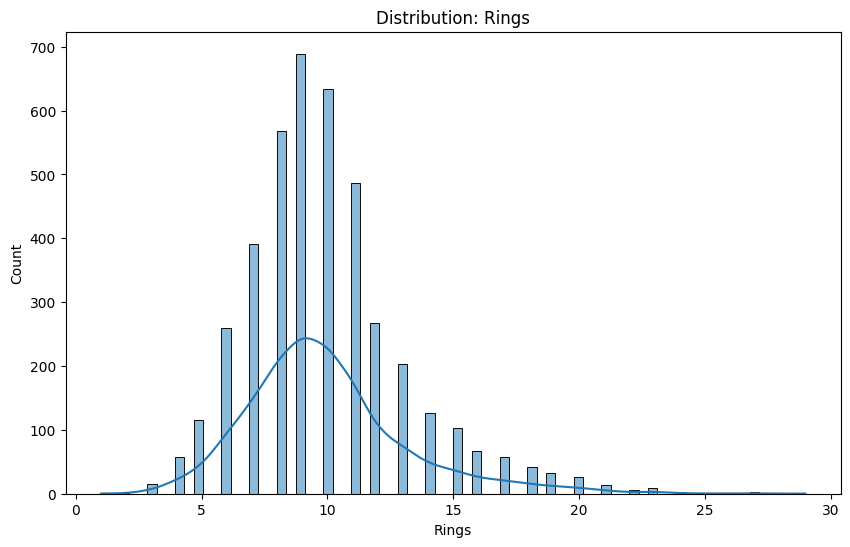

In [93]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(data['Rings'], kde=True)
plt.title('Distribution: Rings')
plt.show()

Leveraging this information might improve the network's performance.

Modifications:
1. Apply log transformation of the target variable to normalise the distribution.
2. Modify the neural network to output the mean and log-variance of a Gaussian distribution.
3. Utilise negative log-likelihood loss function, as it is more appropirate for a Gaussian target distribution.

In [94]:
data['Sex'] = data['Sex'].map({'M': 0, 'F': 1, 'I': 2})

X = data.drop('Rings', axis=1).values
y = data['Rings'].values

y_log = np.log1p(y)

In [95]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_log, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

In [96]:
class GaussianAbaloneNet(nn.Module):
    def __init__(self, input_size):
        super(GaussianAbaloneNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 2)
    
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        mean, log_var = self.fc3(x).chunk(2, dim=1)
        return mean, log_var

In [97]:
def gaussian_nll_loss(mean, log_var, targets):
    variance = torch.exp(log_var)
    return 0.5 * torch.mean(torch.log(2 * np.pi * variance) + (targets - mean) ** 2 / variance)

In [98]:
input_size = X_train_scaled.shape[1]
net = GaussianAbaloneNet(input_size)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [99]:
num_epochs = 1000
batch_size = 128
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]

        mean, log_var = net(batch_X)
        loss = gaussian_nll_loss(mean, log_var, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    net.eval()
    with torch.no_grad():
        train_mean, train_log_var = net(X_train_tensor)
        train_loss = gaussian_nll_loss(train_mean, train_log_var, y_train_tensor)
        train_losses.append(train_loss.item())
        
        val_mean, val_log_var = net(X_test_tensor)
        val_loss = gaussian_nll_loss(val_mean, val_log_var, y_test_tensor)
        val_losses.append(val_loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')


Epoch [100/1000], Train Loss: -0.5173, Val Loss: -0.3134
Epoch [200/1000], Train Loss: -0.5795, Val Loss: -0.2874
Epoch [300/1000], Train Loss: -0.6445, Val Loss: -0.2225
Epoch [400/1000], Train Loss: -0.6724, Val Loss: -0.1563
Epoch [500/1000], Train Loss: -0.6910, Val Loss: -0.0826
Epoch [600/1000], Train Loss: -0.7149, Val Loss: 0.0657
Epoch [700/1000], Train Loss: -0.7391, Val Loss: 0.2715
Epoch [800/1000], Train Loss: -0.7233, Val Loss: 0.7342
Epoch [900/1000], Train Loss: -0.7817, Val Loss: 0.7134
Epoch [1000/1000], Train Loss: -0.7371, Val Loss: 0.4996


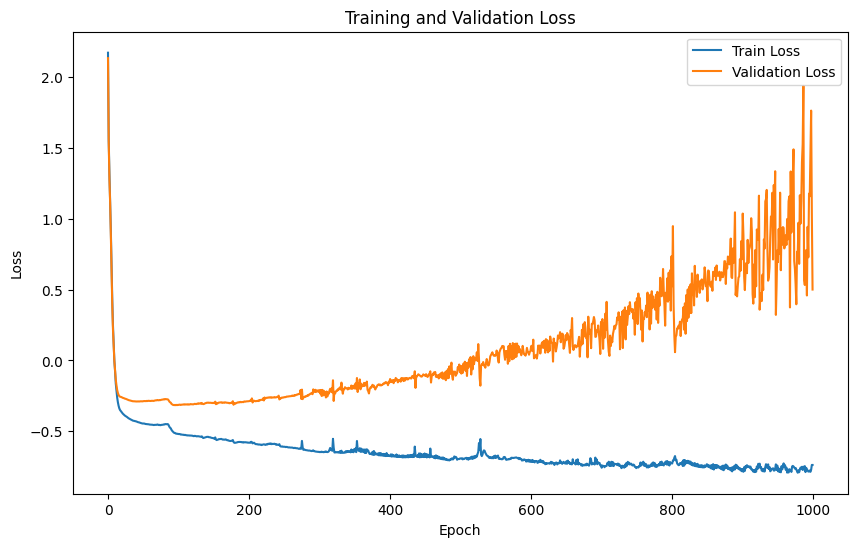

In [100]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
plt.close()

Promising results on the learning curve while training.

In [101]:
net.eval()
with torch.no_grad():
    y_pred_mean, y_pred_log_var = net(X_test_tensor)
    y_pred_mean = y_pred_mean.numpy().flatten()
    y_pred_std = np.sqrt(np.exp(y_pred_log_var.numpy().flatten()))
    y_true = y_test_tensor.numpy().flatten()

y_pred_mean_orig = np.expm1(y_pred_mean)
y_true_orig = np.expm1(y_true)

mae = mean_absolute_error(y_true_orig, y_pred_mean_orig)
mse = mean_squared_error(y_true_orig, y_pred_mean_orig)
r2 = r2_score(y_true_orig, y_pred_mean_orig)

print('Final Results:')
print(f'\tMean Absolute Error: {mae:.4f}')
print(f'\tMean Squared Error: {mse:.4f}')
print(f'\tr2 Score: {r2:.4f}')

Final Results:
	Mean Absolute Error: 1.7352
	Mean Squared Error: 8.7872
	r2 Score: 0.1347


Not better, but shows comparable results. (1.7352 vs 1.4309 - MAE score of probabilistic and plain regression, respectively.)

Seems prone to overfitting, as it explicitly leverages the distribution of rings.